<a href="https://colab.research.google.com/github/eGamez01/cbm_plus/blob/use-case-buildout/cbm_plus_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBM+ Applications

The purpose of this notebook is to demonstrate the use of statistics for CBM+ applications utilizing engine lifecycle data, including sensor information. Some examples of CBM+ applications cases include:
1. Fleet Health Snapshot (Weibull)
2. Spare Pool Sizing (Weibull)
3. Engine Health Ranking (SVM)

Data Overview:

Train: 100 engines lifecycle information with failure cycle identified and operating in same environment (sea-level)

Test: 100 engines lifecycle information and operating in same environment (sea-level). Failure information provided in a separate file for validation.

All data can be found and sourced in Kaggle, url: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps


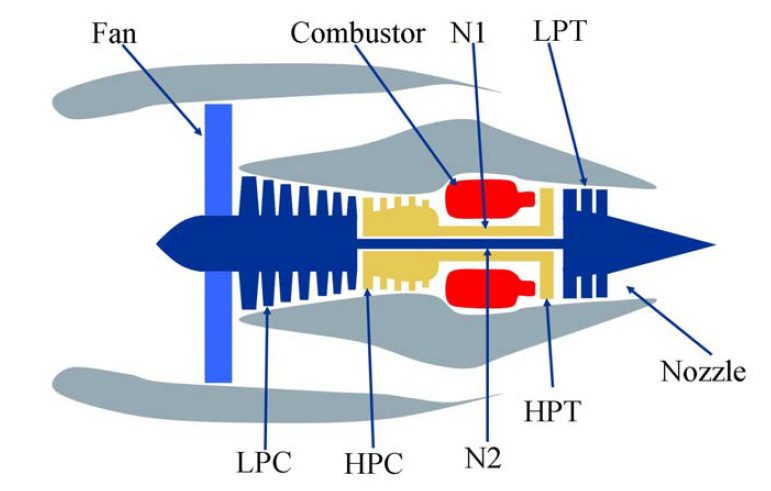

Figure 1: Simplified diagram of engine simulated in C-MAPSS

## Data Exploration

Loaded 20,631 rows for FD001


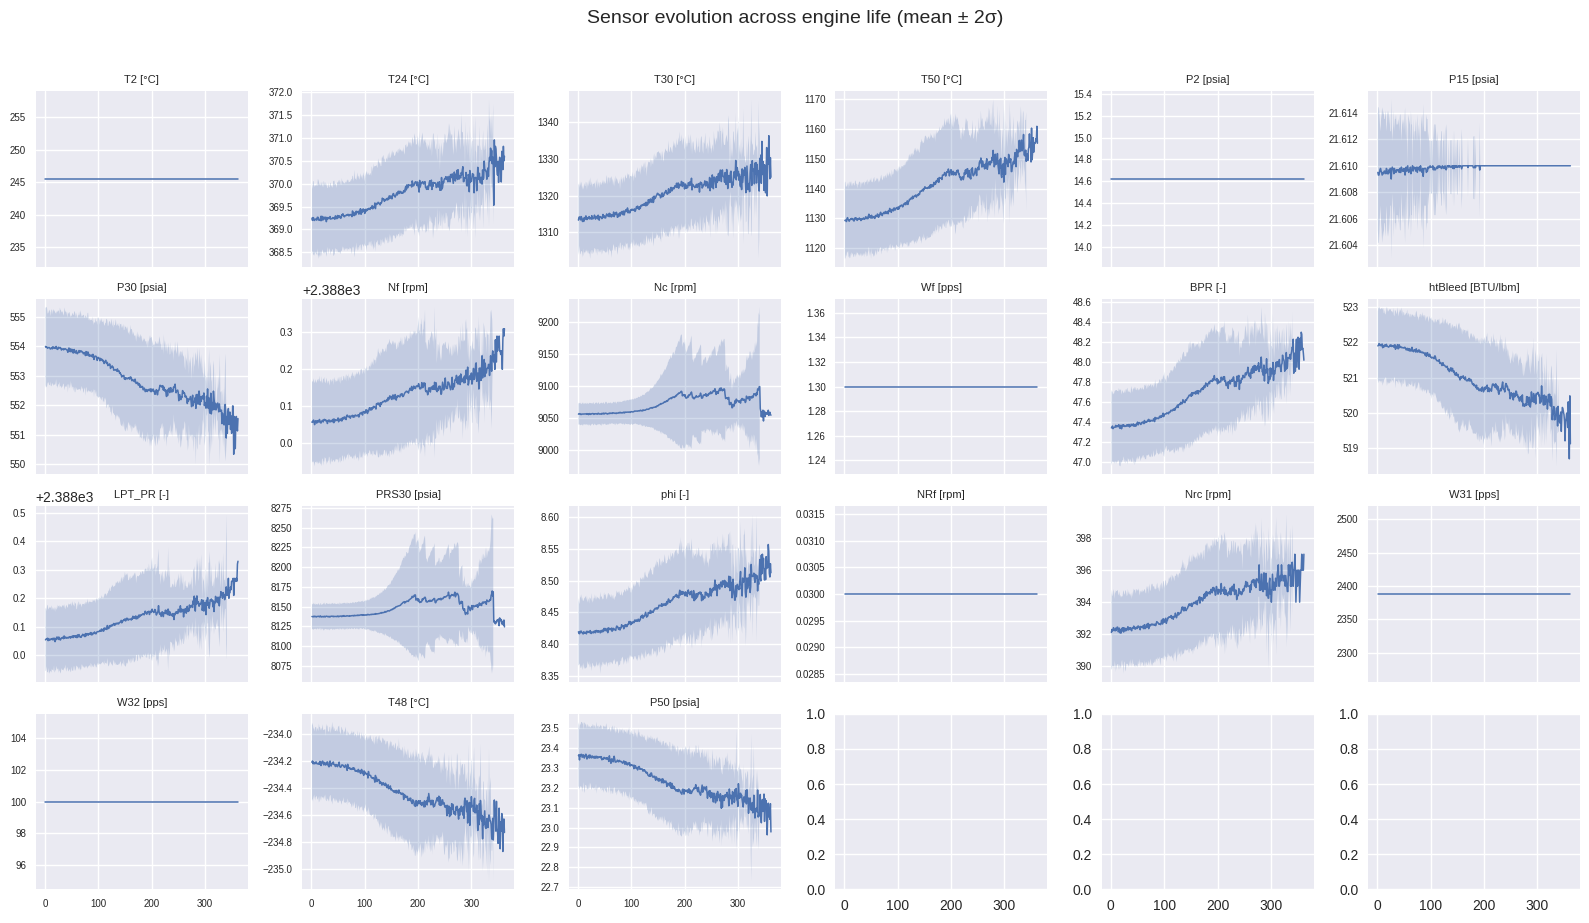


Sensor Glossary
 ID    Code                 Full name    Unit
 s1      T2      Total T at fan inlet      °C
s10      Wf                 Fuel flow     pps
s11     BPR             By-pass ratio       -
s12 htBleed            Bleed enthalpy BTU/lbm
s13  LPT_PR    LPC→LPT pressure ratio       -
s14   PRS30      Static P at HPC exit    psia
s15     phi      Fuel–air ratio proxy       -
s16     NRf  Corrected fan speed ×100     rpm
s17     Nrc Corrected core speed ×100     rpm
s18     W31      LPC bypass-duct flow     pps
s19     W32          HPT coolant flow     pps
 s2     T24     Total T at LPC outlet      °C
s20     T48   HPT coolant temperature      °C
s21     P50      Static P at LPT exit    psia
 s3     T30     Total T at HPC outlet      °C
 s4     T50     Total T at LPT outlet      °C
 s5      P2      Total P at fan inlet    psia
 s6     P15    Total P in bypass duct    psia
 s7     P30     Total P at HPC outlet    psia
 s8      Nf   Physical fan speed ×100     rpm
 s9      Nc  Phys

In [1]:
# ===========================================================
# 0. Imports & plotting style
# ===========================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# ===========================================================
# 1. Load FD001 training set
# ===========================================================
SCENARIO  = "FD001"
BASE_URL  = "https://raw.githubusercontent.com/eGamez01/lfs_data/refs/heads/master"
train_url = f"{BASE_URL}/train_{SCENARIO}.txt"

orig_cols = (["unit", "cycle"] +
             [f"op_setting_{i}" for i in range(1,4)] +
             [f"s{i}" for i in range(1,22)])
train_df = pd.read_csv(train_url, sep=r"\s+", header=None, names=orig_cols)
print(f"Loaded {train_df.shape[0]:,} rows for {SCENARIO}")

# -----------------------------------------------------------
# 2. Sensor name ↔ unit map  (paper + Kelvin→C conversion)
# -----------------------------------------------------------
sensor_info = {
    "s1": ("T2" , "Total T at fan inlet",          "°C", True),
    "s2": ("T24", "Total T at LPC outlet",         "°C", True),
    "s3": ("T30", "Total T at HPC outlet",         "°C", True),
    "s4": ("T50", "Total T at LPT outlet",         "°C", True),
    "s5": ("P2" , "Total P at fan inlet",          "psia", False),
    "s6": ("P15", "Total P in bypass duct",        "psia", False),
    "s7": ("P30", "Total P at HPC outlet",         "psia", False),
    "s8": ("Nf" , "Physical fan speed ×100",       "rpm", False),
    "s9": ("Nc" , "Physical core speed ×100",      "rpm", False),
    "s10":("Wf" , "Fuel flow",                     "pps", False),
    "s11":("BPR", "By-pass ratio",                 "-",   False),
    "s12":("htBleed","Bleed enthalpy",         "BTU/lbm",False),
    "s13":("LPT_PR","LPC→LPT pressure ratio",      "-",   False),
    "s14":("PRS30","Static P at HPC exit",         "psia",False),
    "s15":("phi",   "Fuel–air ratio proxy",        "-",   False),
    "s16":("NRf",  "Corrected fan speed ×100",     "rpm", False),
    "s17":("Nrc",  "Corrected core speed ×100",    "rpm", False),
    "s18":("W31",  "LPC bypass-duct flow",         "pps", False),
    "s19":("W32",  "HPT coolant flow",             "pps", False),
    "s20":("T48",  "HPT coolant temperature",      "°C", True),
    "s21":("P50",  "Static P at LPT exit",         "psia",False)
}
op_map = {"op_setting_1":"alt [ft×100]",
          "op_setting_2":"mach [-]",
          "op_setting_3":"TRA [deg]"}

# Rename columns and convert temperatures
rename_dict = {}
for key, (code, _, unit, is_temp) in sensor_info.items():
    new_col = f"{code} [{unit}]"
    rename_dict[key] = new_col
    if is_temp:
        train_df[key] = train_df[key] - 273.15    # K → °C

train_df.rename(columns={**rename_dict, **op_map}, inplace=True)
sensor_cols = list(rename_dict.values())

# -----------------------------------------------------------
# 3. Sensor evolution plot  (mean ± 2σ, now °C shown)
# -----------------------------------------------------------
ROWS, COLS = 4, 6
fig, axs = plt.subplots(ROWS, COLS, figsize=(16,9), sharex=True)

for idx, col in enumerate(sensor_cols):
    r, c = divmod(idx, COLS)
    grp  = train_df.groupby('cycle')[col]
    μ, σ = grp.mean(), grp.std()
    axs[r, c].plot(μ.index, μ, lw=1.1)
    axs[r, c].fill_between(μ.index, μ-2*σ, μ+2*σ, alpha=.25)
    axs[r, c].set_title(col, fontsize=8)
    axs[r, c].tick_params(labelsize=7)

fig.suptitle("Sensor evolution across engine life (mean ± 2σ)", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

# -----------------------------------------------------------
# 4. Sensor glossary print-out
# -----------------------------------------------------------
glossary = pd.DataFrame([{
        "ID": key,
        "Code": info[0],
        "Full name": info[1],
        "Unit": info[2]
    } for key, info in sensor_info.items()]).sort_values("ID")

print("\nSensor Glossary")
print(glossary.to_string(index=False))


## Fleet-wide Statistics

### Weibull and Gamma Distributions

Loaded 20,631 rows from train_FD001.txt
100 engines – life range 128-362 cycles

— Parameter fits —
Weibull  : β=4.409,  η=225.026
Gamma    : k=21.778, θ=9.473

— Model scores —
Weibull  LL=-530.75,  AIC=1065.50
Gamma    LL=-519.24, AIC=1042.48


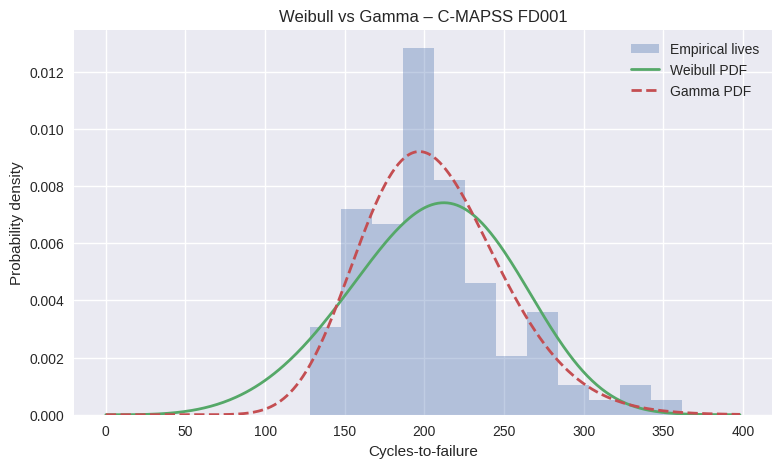

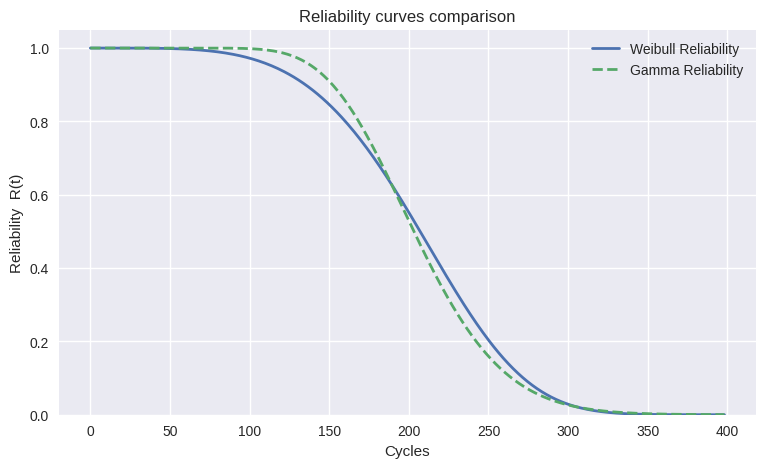

In [2]:
# -----------------------------------------------------------
# 0. Imports
# -----------------------------------------------------------
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import weibull_min, gamma

# -----------------------------------------------------------
# 1. Column layout (define BEFORE loading)
# -----------------------------------------------------------
cols = (["unit", "cycle"] +
        [f"op_setting_{i}" for i in range(1, 4)] +
        [f"s{i}"           for i in range(1, 22)])

# -----------------------------------------------------------
# 2. Read directly from the GitHub raw link
# -----------------------------------------------------------
SCENARIO  = "FD001"          # FD001 | FD002 | FD003 | FD004
base_url  = "https://raw.githubusercontent.com/eGamez01/lfs_data/refs/heads/master"
train_url = f"{base_url}/train_{SCENARIO}.txt"

# -----------------------------------------------------------
# 3. Load the training data
# -----------------------------------------------------------
train_df = pd.read_csv(train_url, sep=r"\s+", header=None, names=cols)
print(f"Loaded {train_df.shape[0]:,} rows from {train_url.split('/')[-1]}")


# -----------------------------------------------------------
# 3. Derive each engine’s life (cycles-to-failure)
# -----------------------------------------------------------
lifes = train_df.groupby("unit")["cycle"].max().to_numpy()
print(f"{lifes.size} engines – life range {lifes.min()}-{lifes.max()} cycles")

# -----------------------------------------------------------
# 4a. Weibull (2-param) fit
# -----------------------------------------------------------
beta, _, eta = weibull_min.fit(lifes, floc=0)        # shape, loc=0, scale
# 4b. Gamma (2-param) fit
k_gamma, _, theta_gamma = gamma.fit(lifes, floc=0)   # shape, loc=0, scale

# -----------------------------------------------------------
# 5. Optional: log-likelihood & AIC for quick comparison
# -----------------------------------------------------------
ll_weib  = weibull_min.logpdf(lifes, beta,      0, eta        ).sum()
ll_gamma = gamma      .logpdf(lifes, k_gamma,   0, theta_gamma).sum()
aic_weib  = 2*2 - 2*ll_weib       # 2 parameters (β,η)
aic_gamma = 2*2 - 2*ll_gamma      # 2 parameters (k,θ)

print("\n— Parameter fits —")
print(f"Weibull  : β={beta:.3f},  η={eta:.3f}")
print(f"Gamma    : k={k_gamma:.3f}, θ={theta_gamma:.3f}")
print("\n— Model scores —")
print(f"Weibull  LL={ll_weib:.2f},  AIC={aic_weib:.2f}")
print(f"Gamma    LL={ll_gamma:.2f}, AIC={aic_gamma:.2f}")

# -----------------------------------------------------------
# 6. Build PDF & Reliability curves for overlay
# -----------------------------------------------------------
t = np.linspace(0, lifes.max()*1.1, 400)

pdf_weib  = weibull_min.pdf(t,  beta,    0, eta)
pdf_gamma = gamma.pdf(       t, k_gamma, 0, theta_gamma)

rel_weib  = 1 - weibull_min.cdf(t, beta,    0, eta)
rel_gamma = 1 - gamma.cdf(       t, k_gamma, 0, theta_gamma)

# -----------------------------------------------------------
# 7. Plot PDF over histogram
# -----------------------------------------------------------
plt.figure(figsize=(9,5))
plt.hist(lifes, bins=12, density=True, alpha=.35, label="Empirical lives")
plt.plot(t, pdf_weib,  lw=2, label="Weibull PDF")
plt.plot(t, pdf_gamma, lw=2, label="Gamma PDF", ls="--")
plt.xlabel("Cycles-to-failure");  plt.ylabel("Probability density")
plt.title(f"Weibull vs Gamma – C-MAPSS {SCENARIO}")
plt.legend()
plt.show()

# -----------------------------------------------------------
# 8. Plot reliability curves on same axes
# -----------------------------------------------------------
plt.figure(figsize=(9,5))
plt.plot(t, rel_weib,  lw=2, label="Weibull Reliability")
plt.plot(t, rel_gamma, lw=2, label="Gamma Reliability", ls="--")
plt.xlabel("Cycles");  plt.ylabel("Reliability  R(t)")
plt.title("Reliability curves comparison")
plt.ylim(0, 1.05); plt.legend()
plt.show()

### Fleet snapshot (Weibull)


In [3]:
test_url = f"{base_url}/test_{SCENARIO}.txt"
test_df  = pd.read_csv(test_url, sep=r"\s+", header=None, names=cols)

ages = test_df.groupby("unit")["cycle"].max().to_numpy(dtype=float)
N_fleet = len(ages)
avg_age = ages.mean()

print(f"\n🛩️  Fleet in service: {N_fleet} engines")
print(f"   • Average age : {avg_age:.1f} cycles\n")

# ---- 15-cycle (≈ month) horizon -----------------------
Δ = 15            # cycles per engine for the next month-lite

def p_fail_weib(t, delta):
    S_t  = 1 - weibull_min.cdf(t,       beta, 0, eta)
    S_td = 1 - weibull_min.cdf(t+delta, beta, 0, eta)
    return 1 - S_td / S_t

def p_fail_gamma(t, delta):
    S_t  = 1 - gamma.cdf(t,       k_gamma, 0, theta_gamma)
    S_td = 1 - gamma.cdf(t+delta, k_gamma, 0, theta_gamma)
    return 1 - S_td / S_t

p_w = p_fail_weib(ages, Δ)
p_g = p_fail_gamma(ages, Δ)

exp_w = p_w.sum()
exp_g = p_g.sum()

print(f"Expected removals over the next {Δ} cycles per engine:")
print(f"   • Weibull : {exp_w:.2f} engines")
print(f"   • Gamma   : {exp_g:.2f} engines")


🛩️  Fleet in service: 100 engines
   • Average age : 131.0 cycles

Expected removals over the next 15 cycles per engine:
   • Weibull : 8.28 engines
   • Gamma   : 8.92 engines


### Spare Pool Sizing (Weibull)

In [4]:
import math

# -------- context (already defined above) ------------------
N_fleet = len(ages)       # engines on wing
Δ       = 15              # cycles you chose for the next month-lite
RISK_TOL = 0.10

# -------- spare-pool sizing --------------------------------
spares = 0
while True:
    # Poisson-binomial → normal tail approx
    p_total   = p_w.sum()
    var_total = (p_w * (1 - p_w)).sum()
    z         = (spares + 0.5 - p_total) / math.sqrt(var_total + 1e-9)
    shortage_prob = 0.5 * (1 - math.erf(z / math.sqrt(2)))  # Φ̄(z)
    if shortage_prob <= RISK_TOL:
        break
    spares += 1

# -------- presentation -------------------------------------
spare_ratio  = 100 * spares / N_fleet
fleet_cycles = N_fleet * Δ

CYCLES_PER_MONTH = 15          # ➊ one “month” ≈ 15 cycles/engine
months = Δ / CYCLES_PER_MONTH
month_txt = f"{months:.1f} month" + ("s" if months != 1 else "")

print(f"\nSpare engines required (Weibull, ≤{RISK_TOL:.0%} risk): {spares}")
print(f"Spare ratio  : {spare_ratio:.1f}%  ({spares}/{N_fleet} engines)")
print(f"Fleet usage  : {fleet_cycles:,} engine-cycles "
      f"expected over the next {month_txt} "
      f"({Δ} cycles per engine)")




Spare engines required (Weibull, ≤10% risk): 12
Spare ratio  : 12.0%  (12/100 engines)
Fleet usage  : 1,500 engine-cycles expected over the next 1.0 month (15 cycles per engine)


## Engine Remaining Useful Life

### Model Testing

#### LSTM

In [5]:
# ===========================================================
# 0. Imports & config  (run once)
# ===========================================================
import time, random, os, numpy as np, pandas as pd, tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import layers, models

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ===========================================================
# DATA PATHS – use raw-GitHub links
# ===========================================================
SCENARIO = "FD001"          # "FD001" | "FD002" | "FD003" | "FD004"
SEQ_LEN  = 30


train_file = f"{base_url}/train_{SCENARIO}.txt"
test_file  = f"{base_url}/test_{SCENARIO}.txt"
rul_file   = f"{base_url}/RUL_{SCENARIO}.txt"

# Column names
cols = (["unit","cycle"] +
        [f"op_setting_{i}" for i in range(1,4)] +
        [f"s{i}" for i in range(1,22)])

# ===========================================================
# 1. Load & pre-process
# ===========================================================
train_df = pd.read_csv(train_file, sep=r"\s+", header=None, names=cols)
test_df  = pd.read_csv(test_file,  sep=r"\s+", header=None, names=cols)
rul_truth = pd.read_csv(rul_file,  header=None, names=["RUL_true"])


# Add RUL label to train set
max_cycle = train_df.groupby("unit")["cycle"].max()
train_df["RUL"] = train_df.apply(lambda r: max_cycle[r["unit"]] - r["cycle"], axis=1)

# Normalise 24 sensor + op-setting columns
feat_cols = cols[2:]
scaler    = MinMaxScaler()
train_df[feat_cols] = scaler.fit_transform(train_df[feat_cols])
test_df[feat_cols]  = scaler.transform(test_df[feat_cols])

# Make supervised windows
def make_windows(df, seq_len=30):
    X, y = [], []
    for uid, grp in df.groupby("unit"):
        grp = grp.sort_values("cycle")
        f   = grp[feat_cols].values
        r   = grp["RUL"].values if "RUL" in grp else None
        for i in range(len(grp)):
            win = f[max(0, i-seq_len+1):i+1]
            if len(win) < seq_len:
                win = np.pad(win, ((seq_len-len(win),0),(0,0)), 'constant')
            X.append(win)
            if r is not None: y.append(r[i])
    return np.asarray(X, np.float32), (np.asarray(y, np.float32) if y else None)

X_train, y_train = make_windows(train_df, SEQ_LEN)

# Last-row snapshot for each test engine
def last_snapshot(df, seq_len=30):
    X = []
    for _, grp in df.groupby("unit"):
        grp = grp.sort_values("cycle")
        seq = grp[feat_cols].tail(seq_len).values
        if len(seq) < seq_len:
            seq = np.pad(seq, ((seq_len-len(seq),0),(0,0)), 'constant')
        X.append(seq)
    return np.asarray(X, np.float32)


X_test = last_snapshot(test_df, SEQ_LEN)
y_test = rul_truth["RUL_true"].to_numpy(dtype=np.float32)

# ===========================================================
# 2. Build LSTM
# ===========================================================
model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, len(feat_cols))),
    layers.Masking(mask_value=0.0),
    layers.LSTM(64, dropout=0.2, use_cudnn=False), # Disable cuDNN
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mae')

# ===========================================================
# 3. Train + time
# ===========================================================
tic = time.perf_counter()
hist = model.fit(X_train, y_train,
                 validation_split=0.1,
                 epochs=20, batch_size=64, verbose=0)
train_time = time.perf_counter() - tic

# ===========================================================
# 4. Predict + time
# ===========================================================
tic = time.perf_counter()
y_pred = model.predict(X_test, verbose=0).flatten()
pred_time = time.perf_counter() - tic

# Clip negatives
y_pred = np.clip(y_pred, 0, None)

# ===========================================================
# 5. Metrics
# ===========================================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred) * 100   # %
total_time = train_time + pred_time

# ===========================================================
# 6. Display results in comparison table format
# ===========================================================
result = pd.DataFrame([{
    "Model":          "LSTM",
    "R2":             f"{r2:.2f}%",
    "RMSE":           f"{rmse:.2f}",
    "time to train":  f"{train_time:.3f}",
    "time to predict":f"{pred_time:.3f}",
    "total time":     f"{total_time:.3f}"
}])

print(result.to_string(index=False))

Model     R2  RMSE time to train time to predict total time
 LSTM 31.98% 34.27       116.672           0.504    117.176


#### Random Forest

In [6]:
# ===========================================================
# Random Forest benchmark
# ===========================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# 1. Flatten 3-D sequences → 2-D feature matrices
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0],  -1))

# 2. Build & time the Random Forest
rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=SEED,
        oob_score=False,
        verbose=0)

tic = time.perf_counter()
rf.fit(X_train_flat, y_train)
train_time_rf = time.perf_counter() - tic

tic = time.perf_counter()
y_pred_rf = rf.predict(X_test_flat)
pred_time_rf = time.perf_counter() - tic

# 3. Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf) * 100
total_rf = train_time_rf + pred_time_rf

# 4. Append to the comparison table
result = pd.concat([result, pd.DataFrame([{
    "Model":           "Random Forest",
    "R2":              f"{r2_rf:.2f}%",
    "RMSE":            f"{rmse_rf:.2f}",
    "time to train":   f"{train_time_rf:.3f}",
    "time to predict": f"{pred_time_rf:.3f}",
    "total time":      f"{total_rf:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547


#### SVM

In [7]:
# ===========================================================
# Support-Vector Regression benchmark (RBF kernel)
# ===========================================================
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import time

# ---- 1. Build & time the SVR -----------------------------------------
svm = SVR(kernel="rbf", C=100, epsilon=0.1, gamma="scale")  # baseline parms

tic = time.perf_counter()
svm.fit(X_train_flat, y_train)
train_time_svm = time.perf_counter() - tic

tic = time.perf_counter()
y_pred_svm = svm.predict(X_test_flat)
pred_time_svm = time.perf_counter() - tic

# ---- 2. Metrics -------------------------------------------------------
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm   = r2_score(y_test, y_pred_svm) * 100
total_svm = train_time_svm + pred_time_svm

# ---- 3. Append to comparison table ------------------------------------
result = pd.concat([result, pd.DataFrame([{
    "Model":           "SVM",
    "R2":              f"{r2_svm:.2f}%",
    "RMSE":            f"{rmse_svm:.2f}",
    "time to train":   f"{train_time_svm:.3f}",
    "time to predict": f"{pred_time_svm:.3f}",
    "total time":      f"{total_svm:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547
          SVM 74.94% 20.80       253.416           1.712    255.128


#### KNN

In [8]:
# ===========================================================
# k-Nearest-Neighbors Regression benchmark
# ===========================================================
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# 1. Initialise KNN (distance-weighted, k=7 is a good default for FD001)
knn = KNeighborsRegressor(
        n_neighbors=7,
        weights="distance",      # closer neighbors weigh more
        metric="minkowski",      # Euclidean distance
        n_jobs=-1)

# 2. Train & time  (fit() is trivial for KNN)
tic = time.perf_counter()
knn.fit(X_train_flat, y_train)
train_time_knn = time.perf_counter() - tic

# 3. Predict & time  (prediction does the heavy lifting)
tic = time.perf_counter()
y_pred_knn = knn.predict(X_test_flat)
pred_time_knn = time.perf_counter() - tic

# 4. Metrics
rmse_knn  = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn    = r2_score(y_test, y_pred_knn) * 100
total_knn = train_time_knn + pred_time_knn

# 5. Append to comparison table
result = pd.concat([result, pd.DataFrame([{
    "Model":           "kNN",
    "R2":              f"{r2_knn:.2f}%",
    "RMSE":            f"{rmse_knn:.2f}",
    "time to train":   f"{train_time_knn:.3f}",
    "time to predict": f"{pred_time_knn:.3f}",
    "total time":      f"{total_knn:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547
          SVM 74.94% 20.80       253.416           1.712    255.128
          kNN 38.72% 32.53         0.007           0.173      0.180


#### XGBoost

In [9]:
# ======= XGBoost Regressor =================================================
#!pip -q install xgboost          # Kaggle/Colab: silent install

from xgboost import XGBRegressor
import time, numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=SEED)

tic = time.perf_counter()
xgb.fit(X_train_flat, y_train)
train_time_xgb = time.perf_counter() - tic

tic = time.perf_counter()
y_pred_xgb = xgb.predict(X_test_flat)
pred_time_xgb = time.perf_counter() - tic

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb   = r2_score(y_test, y_pred_xgb) * 100
total_xgb = train_time_xgb + pred_time_xgb

result = pd.concat([result, pd.DataFrame([{
    "Model":           "XGBoost",
    "R2":              f"{r2_xgb:.2f}%",
    "RMSE":            f"{rmse_xgb:.2f}",
    "time to train":   f"{train_time_xgb:.3f}",
    "time to predict": f"{pred_time_xgb:.3f}",
    "total time":      f"{total_xgb:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547
          SVM 74.94% 20.80       253.416           1.712    255.128
          kNN 38.72% 32.53         0.007           0.173      0.180
      XGBoost 65.55% 24.39        32.244           0.005     32.249


#### GPT

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

SEQ_LEN  = 30       # time steps
FEAT_DIM = 24       # sensors + op settings
EMB_DIM  = 64       # token dimension
NUM_HEAD = 2
NUM_LAY  = 2

# --- inputs -----------------------------------------------------------
inp = layers.Input(shape=(SEQ_LEN, FEAT_DIM))

# 1. Linear projection to token space
tok = layers.TimeDistributed(layers.Dense(EMB_DIM))(inp)

# 2. Add learnable positional embeddings
pos_emb = tf.Variable(tf.random.uniform((SEQ_LEN, EMB_DIM)), name="pos_emb")
tok += pos_emb

# 3. Transformer blocks
x = tok
for _ in range(NUM_LAY):
    # Multi-head self-attention
    attn = layers.MultiHeadAttention(NUM_HEAD, EMB_DIM//NUM_HEAD)(x, x)
    x    = layers.LayerNormalization()(x + attn)          # residual
    # Feed-forward
    ff   = layers.Dense(4*EMB_DIM, activation='gelu')(x)
    ff   = layers.Dense(EMB_DIM)(ff)
    x    = layers.LayerNormalization()(x + ff)            # residual

# 4. Pool (take representation of last token)
pooled = x[:, -1, :]           # (batch, EMB_DIM)
out    = layers.Dense(1)(pooled)

model = tf.keras.Model(inp, out)
model.compile(optimizer='adam', loss='mae')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 64)    │      1,600 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 64)    │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     16,640 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 256)   │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 30, 64)    │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30, 256)   │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30, 64)    │     16,448 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ get_item[0][0]  

 Total params: 101,633 (397.00 KB)

 Trainable params: 101,633 (397.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np, time

# -----------------------------------------------------------
# 1. Train the tiny-GPT model
# -----------------------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=64,
    verbose=0)

# -----------------------------------------------------------
# 2. Predict on the test snapshot
# -----------------------------------------------------------
tic = time.perf_counter()
y_pred = model.predict(X_test, verbose=0).flatten()
pred_time = time.perf_counter() - tic

# Guard against negatives
y_pred = np.clip(y_pred, 0, None)

# -----------------------------------------------------------
# 3. Calculate metrics
# -----------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred) * 100     # as %
print(f"R²  : {r2:.2f}%")
print(f"RMSE: {rmse:.2f} cycles")
print(f"Prediction time for {len(y_test)} engines: {pred_time:.3f} s")

# -----------------------------------------------------------
# 4. (Optional) append to your results DataFrame
# -----------------------------------------------------------
result = pd.concat([result, pd.DataFrame([{
    "Model":           "Tiny GPT",
    "R2":              f"{r2:.2f}%",
    "RMSE":            f"{rmse:.2f}",
    "time to train":   f"{history.history['loss'][-1]:.3f}",  # or use a timer if you recorded one
    "time to predict": f"{pred_time:.3f}",
    "total time":      "--"    # fill if you timed training
}])], ignore_index=True)

print(result.to_string(index=False))


R²  : 76.68%
RMSE: 20.07 cycles
Prediction time for 100 engines: 1.075 s
        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547
          SVM 74.94% 20.80       253.416           1.712    255.128
          kNN 38.72% 32.53         0.007           0.173      0.180
      XGBoost 65.55% 24.39        32.244           0.005     32.249
     Tiny GPT 76.68% 20.07        16.221           1.075         --


#### CNN

In [12]:
# ===========================================================
# Convolutional-Neural-Net benchmark  (1-D CNN)
#    - two Conv1D blocks + global average pool
# ===========================================================
import tensorflow as tf, time
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np, pandas as pd

tf.random.set_seed(SEED)

SEQ_LEN, FEAT_DIM = X_train.shape[1], X_train.shape[2]

cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN, FEAT_DIM)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

cnn.compile(optimizer='adam', loss='mae')

# ---- train & time ----------------------------------------
tic = time.perf_counter()
cnn.fit(X_train, y_train,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                     patience=6, restore_best_weights=True)],
        verbose=0)
train_time_cnn = time.perf_counter() - tic

# ---- predict & time --------------------------------------
tic = time.perf_counter()
y_pred_cnn = cnn.predict(X_test, verbose=0).flatten()
pred_time_cnn = time.perf_counter() - tic

y_pred_cnn = np.clip(y_pred_cnn, 0, None)

# ---- metrics ---------------------------------------------
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
r2_cnn   = r2_score(y_test, y_pred_cnn) * 100
total_cnn = train_time_cnn + pred_time_cnn

# ---- add to leaderboard ----------------------------------
result = pd.concat([result, pd.DataFrame([{
    "Model":           "CNN-1D",
    "R2":              f"{r2_cnn:.2f}%",
    "RMSE":            f"{rmse_cnn:.2f}",
    "time to train":   f"{train_time_cnn:.3f}",
    "time to predict": f"{pred_time_cnn:.3f}",
    "total time":      f"{total_cnn:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


        Model     R2  RMSE time to train time to predict total time
         LSTM 31.98% 34.27       116.672           0.504    117.176
Random Forest 63.18% 25.21       333.484           0.064    333.547
          SVM 74.94% 20.80       253.416           1.712    255.128
          kNN 38.72% 32.53         0.007           0.173      0.180
      XGBoost 65.55% 24.39        32.244           0.005     32.249
     Tiny GPT 76.68% 20.07        16.221           1.075         --
       CNN-1D 62.07% 25.59        21.164           0.245     21.409


### Engine Health Ranking (SVM)

In [14]:
import numpy as np, pandas as pd, random

# 1. Predict RUL for every test engine
X_flat   = X_test.reshape(X_test.shape[0], -1)
rul_pred = svm.predict(X_flat).clip(min=0)

fleet_df = pd.DataFrame({
    "unit": test_df.groupby('unit').size().index,
    "Pred_RUL": rul_pred
})

# 2. Randomly assign each tail to one of 3 squadrons
random.seed(SEED)
squad_map = {u: random.choice(['SQ1', 'SQ2', 'SQ3'])
             for u in fleet_df['unit']}

fleet_df['Squadron'] = fleet_df['unit'].map(squad_map)

# 3. For each squadron, pick the 3 healthiest engines
mission_roster = (
    fleet_df
    .sort_values('Pred_RUL', ascending=False)        # healthiest on top
    .groupby('Squadron')
    .head(3)                                         # 5 per squadron
    .sort_values(['Squadron', 'Pred_RUL'], ascending=[True, False])
    .reset_index(drop=True)
)

print("Mission roster (top-3 RUL engines per squadron):")
print(mission_roster.to_string(index=False, formatters={
      'Pred_RUL': lambda x: f"{x:6.1f}"}))


Mission roster (top-3 RUL engines per squadron):
 unit Pred_RUL Squadron
    2    135.7      SQ1
   69    133.8      SQ1
   26    130.9      SQ1
   78    205.8      SQ2
   39    165.1      SQ2
   83    154.7      SQ2
   65    171.5      SQ3
   23    156.5      SQ3
   85    153.8      SQ3
